In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import logging
import seaborn as sns
from sklearn import preprocessing


In [3]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
# Separate target variable and predictors
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)
y_train = np.log(train_df['SalePrice'])  # Transform target variable with logarithm
X_test = test_df.drop(['Id'], axis=1)

In [6]:
test_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Data Cleaning

#### Data format modification

In [7]:
def convert_object_to_numeric(data,object_type_features):

        '''
        To convert the datatype of certain columns from object to numeric

        Parameters:
        - data : Dataset
        - object_type_features : A list of features that need to be transformed from object to numeric e.g. ['f1','f2'..]
        '''
        data[object_type_features] = data[object_type_features].apply(pd.to_numeric, errors='coerce')
        return data

In [8]:
# Identify numeric columns (where values can be converted to numeric)
numerical_cols_train = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
numerical_cols_test = X_test.select_dtypes(include=['int', 'float']).columns.tolist()

In [9]:
X_train[numerical_cols_train]= X_train[numerical_cols_train].apply(pd.to_numeric)

In [10]:
X_test[numerical_cols_test]= X_test[numerical_cols_test].apply(pd.to_numeric)

#### Drop unnecessary features

In [11]:
def drop_features(data,features_to_drop):

        '''
        To drop certain features from the dataset either on the basis of domain knowledge or feature engineering

        Parameters:
        - data : Dataset
        - features_to_drop : Features one intends to drop from the existing dataframe e.g. [f1,f2,f3,..]
        '''
        for feature in features_to_drop:
            del data[feature]
        return data

#### Handling NaN values

In [12]:
def drop_na (data, threshold = 0.7):

    	data = data.loc[:, data.isnull().sum() < threshold * data.shape[0]]

    	return data

In [13]:
X_train = drop_na(X_train)

In [14]:
X_test = drop_na(X_test)

In [15]:
def impute_data(data,strategy = 'mean',features_to_impute=[]):

        '''
        To impute values in columns with missing data

        Parameters:
        - data : Dataset
        - strategy : Imputation based on mean, median, most_frequent or a constant value. Can be set based on the requirements
        - features_to_impute : Columns with missing values where imputation is required
        ''' # Ideally can be done in a single line
        	# To add: Imputation with KNN

        if(strategy == 'mean'):
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        elif(strategy == 'median'):
            imputer = SimpleImputer(missing_values=np.nan,strategy= 'median')
        elif(strategy == 'most_frequent'):
            imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        elif(strategy == 'constant'):
            imputer = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)

        imputer = imputer.fit(data.loc[:,features_to_impute])
        imputer = imputer.transform(data.loc[:,features_to_impute])
        imputed_data = pd.DataFrame(imputer,columns=features_to_impute)
        imputed_data[data.columns.difference(features_to_impute)] = data[data.columns.difference(features_to_impute)]
        return imputed_data

In [16]:
X_train = impute_data(X_train, 'mean' ,numerical_cols_train)

In [17]:
X_test = impute_data(X_test, 'mean' ,numerical_cols_test)

#### Encoding categorical columns

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_categorical_variables(df, method_dict):
    '''
    Encode categorical variables in a DataFrame using specified methods

    Parameters:
    - df : DataFrame
        The DataFrame containing the categorical variables to be encoded
    - method_dict : dict
        A dictionary where keys are column names and values are the encoding methods to use.
        Encoding methods can be 'label' for Label Encoding or 'one-hot' for One-Hot Encoding

    Returns:
    - encoded_df : DataFrame
        The DataFrame with encoded categorical variables
    '''
    encoded_df = df.copy()  # Create a copy of the original DataFrame

    for col, method in method_dict.items():
        if method == 'label':
            label_encoder = LabelEncoder()
            encoded_df[col] = label_encoder.fit_transform(encoded_df[col])
        elif method == 'one-hot':
            encoded_df = pd.get_dummies(encoded_df, columns=[col])

    return encoded_df


In [19]:

object_cols = X_train.select_dtypes(include=['object']).columns.tolist()

object_cols_test = X_test.select_dtypes(include=['object']).columns.tolist()


# Apply one-hot encoding
X_train = pd.get_dummies(X_train, columns=object_cols)

X_test = pd.get_dummies(X_test, columns=object_cols)


# Display the encoded DataFrame
#print(encoded_train_df.head())


In [20]:
print (len(object_cols_test))

39


In [ ]:
# Align columns
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)


In [21]:
X_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,False,False,False,False,False,False,True,False,True,True
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,False,False,False,False,False,False,True,False,True,True
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,False,False,False,False,False,False,True,False,True,True
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,False,False,False,False,False,False,True,False,True,True
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,False,False,False,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,21.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,True,True
1455,160.0,21.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,0.0,...,False,False,False,False,False,False,True,False,True,True
1456,20.0,160.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,0.0,...,False,False,False,False,False,False,True,False,True,True
1457,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,0.0,...,False,False,False,False,False,False,True,False,True,True


#### Remove collinearity

In [22]:
def multicollinearity_eliminator(numerical_data,threshold = 0.90):

        '''
        Remove multicollinearity among the dataset features

        Parameters:
        - numerical_data : Numeric features of the dataset
        - threshold : the value indicates that if the features are X% correlated, drop them. Can be altered based on the requirements
        '''
        corr_matrix = numerical_data.corr().abs()
        sns.heatmap(corr_matrix,cmap=sns.diverging_palette(230, 20, as_cmap=True),square=True, linewidths=.5, cbar_kws={"shrink": .5})
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool_))
        features_to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]
        print("Features to be dropped due to high correlation with other feature:",features_to_drop)
        numerical_data = numerical_data.drop(numerical_data.columns[features_to_drop],axis=1)
        return numerical_data

In [23]:
#train_df_imputed = multicollinearity_eliminator(train_df_imputed.select_dtypes(include=['int64', 'float64']))

In [24]:
#test_df_imputed = multicollinearity_eliminator(test_df_imputed.select_dtypes(include=['int64', 'float64']))

Features to be dropped due to high correlation with other feature: []


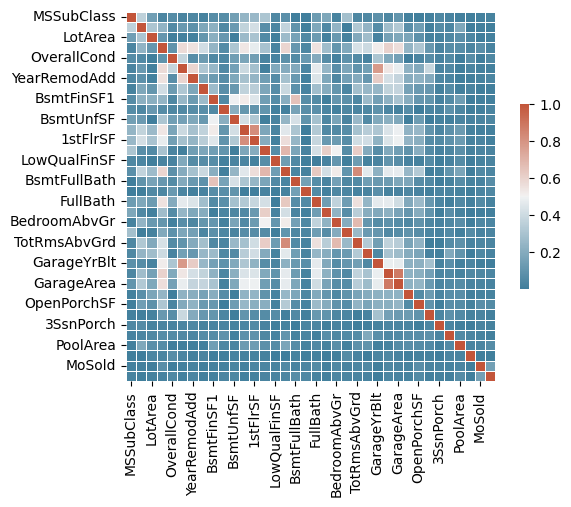

In [25]:
X_train = multicollinearity_eliminator(X_train.select_dtypes(include=['int64', 'float64']))

In [28]:
#encoded_test_df = pd.get_dummies(test_df_imputed, columns=object_cols)


#### Scaling the data

In [29]:
def scale_data(data, scaler='minmax'):

        '''
        To scale the dataset values inorder to ensure consistency and faster convergence

        Parameters:
        - data : Dataset to be scaled
        - scaler : Determines which scaling strategy to adopt - standard, minmax or robust
        '''
        if(scaler == 'standard'):
            scaler = preprocessing.StandardScaler()
            scaled_data = scaler.fit_transform(data[data.columns])
            scaled_data = pd.DataFrame(scaled_data,columns=data.columns)
        elif(scaler == 'minmax'):
            scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
            scaled_data = scaler.fit_transform(data[data.columns])
            scaled_data = pd.DataFrame(scaled_data,columns=data.columns)
        elif(scaler == 'robust'):
            scaler = preprocessing.RobustScaler()
            scaled_data = scaler.fit_transform(data[data.columns])
            scaled_data = pd.DataFrame(scaled_data,columns=data.columns)
        else:
            data = pd.DataFrame(data,columns=data.columns)
        return scaled_data

In [30]:
X_train = scale_data(X_train)

In [31]:
X_test = scale_data(X_test)

In [ ]:
#scaled_test_df = scale_data(encoded_test_df)

In [32]:
def remove_outliers(data):

        '''
        Remove outliers from the dataset

        Parameters:
        - data : Feature set / dataframe
        '''
        first_quartile = data.quantile(0.25)
        third_quartile = data.quantile(0.75)
        interquartile_range = third_quartile - first_quartile
        #print(interquartile_range)
        #print('Before outlier removal, dataset dimension was :',data.shape)
        data = data[~((data < (first_quartile - 1.5 * interquartile_range)) |(data > (third_quartile + 1.5 * interquartile_range))).any(axis=1)]
        #print('After removing outliers, the dimension of the dataset is :',data.shape())
        return data

In [ ]:
#X_train = remove_outliers(X_train)

# Model training

In [33]:
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [34]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [36]:
# Predictions in log scale
predictions_log_scale = model.predict(X_test)

# Convert predictions back from log scale
predictions = np.exp(predictions_log_scale)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

predictions_df.head()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BldgType_1Fam
- BldgType_2fmCon
- BldgType_Duplex
- BldgType_Twnhs
- BldgType_TwnhsE
- ...
